In [1]:
# Aim: Emotion Detection from Text (NLP + Classification)
# Build a model to detect emotions (joy, anger, sadness, etc.) from user-generated
# text like tweets, comments, or messages.

import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.utils import shuffle
import warnings
warnings.filterwarnings('ignore')


In [2]:
tweets = pd.read_csv('tweet_emotions.csv')
tweets.head()

,tweet_id,sentiment,content
0,1956967341,empty,@tiffanylue i know i was listenin to bad habi...
1,1956967666,sadness,Layin n bed with a headache ughhhh...waitin o...
2,1956967696,sadness,Funeral ceremony...gloomy friday...
3,1956967789,enthusiasm,wants to hang out with friends SOON!
4,1956968416,neutral,@dannycastillo We want to trade with someone w...


In [3]:
tweets.isnull().sum()

tweet_id     0
sentiment    0
content      0
dtype: int64

In [4]:
tweets.columns

Index(['tweet_id', 'sentiment', 'content'], dtype='object')

In [5]:
print("Number of columns",tweets.shape[1])
print("Number of rows",tweets.shape[0])

Number of columns 3
Number of rows 40000


In [6]:
tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   tweet_id   40000 non-null  int64 
 1   sentiment  40000 non-null  object
 2   content    40000 non-null  object
dtypes: int64(1), object(2)
memory usage: 937.6+ KB


In [7]:
#Drop extremely rare classes (<200 samples)
class_counts = tweets['sentiment'].value_counts()
valid_classes = class_counts[class_counts >= 200].index
tweets = tweets[tweets['sentiment'].isin(valid_classes)]
tweets = shuffle(tweets, random_state=42).reset_index(drop=True)


In [8]:
# Text Preprocessing
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    text = re.sub(r"\s+", " ", text).strip()
    return text

tweets['clean_content'] = tweets['content'].apply(clean_text)

In [9]:
# Encode Target Labels
le = LabelEncoder()
tweets['sentiment_encoded'] = le.fit_transform(tweets['sentiment'])


In [10]:
# Split Features and Target
X = tweets['clean_content']
y = tweets['sentiment_encoded']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [11]:
# TF-IDF Vectorization with n-grams and stopwords
tfidf = TfidfVectorizer(max_features=8000, ngram_range=(1,2), stop_words='english')
X_train_tfidf = tfidf.fit_transform(X_train)
X_test_tfidf = tfidf.transform(X_test)

In [12]:
# Train Logistic Regression Classifier
lr_model = LogisticRegression(max_iter=1000, multi_class='multinomial', solver='saga')
lr_model.fit(X_train_tfidf, y_train)

LogisticRegression(max_iter=1000, multi_class='multinomial', solver='saga')

In [13]:
# Predictions
y_pred = lr_model.predict(X_test_tfidf)
print("Accuracy:", accuracy_score(y_test, y_pred))

Accuracy: 0.3439506483696336


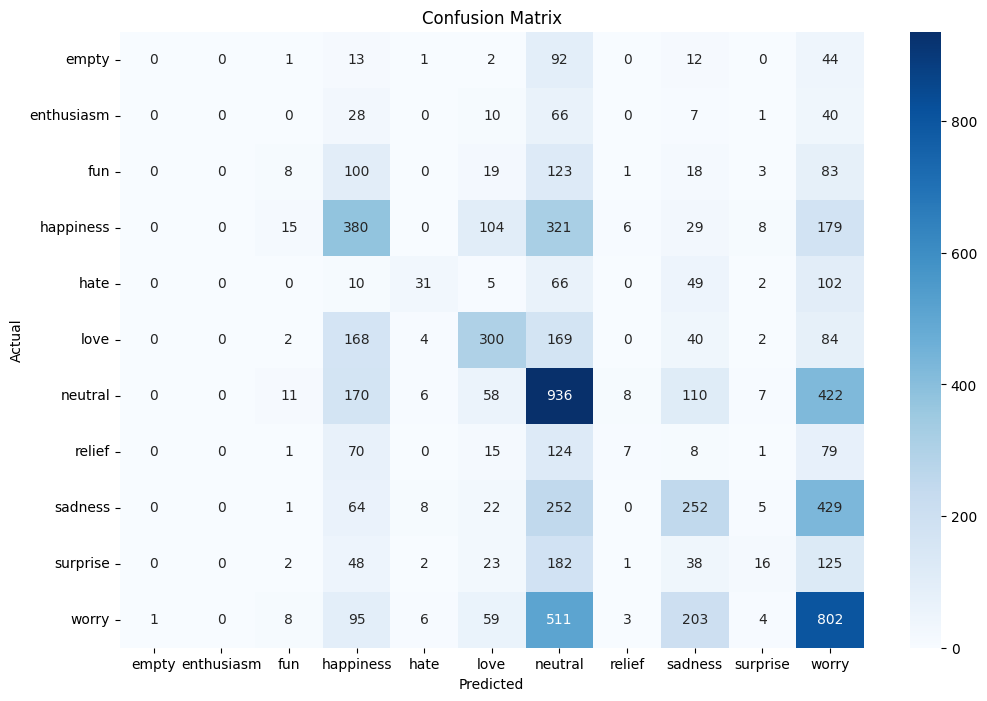


Classification Report:
               precision    recall  f1-score   support

       empty       0.00      0.00      0.00       165
  enthusiasm       0.00      0.00      0.00       152
         fun       0.16      0.02      0.04       355
   happiness       0.33      0.36      0.35      1042
        hate       0.53      0.12      0.19       265
        love       0.49      0.39      0.43       769
     neutral       0.33      0.54      0.41      1728
      relief       0.27      0.02      0.04       305
     sadness       0.33      0.24      0.28      1033
    surprise       0.33      0.04      0.07       437
       worry       0.34      0.47      0.39      1692

    accuracy                           0.34      7943
   macro avg       0.28      0.20      0.20      7943
weighted avg       0.33      0.34      0.31      7943



In [14]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(12,8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

print("\nClassification Report:\n", classification_report(y_test, y_pred, target_names=le.classes_))

In [22]:
# Interactive Prediction
def predict_emotion(text):
    clean = clean_text(text)
    vectorized = tfidf.transform([clean])
    pred = lr_model.predict(vectorized)
    emotion = le.inverse_transform(pred)
    return emotion[0]

user_input = input("Enter a text message: ")
predicted_emotion = predict_emotion(user_input)
print("Predicted Emotion:", predicted_emotion)

Enter a text message:  I am Akshint and I am very happy!


Predicted Emotion: happiness


In [23]:
# Test with Custom Inputs
sample_texts = [
    "I am feeling very happy today!",
    "This is the worst day of my life.",
    "I love spending time with my friends.",
    "I am really scared about tomorrow's exam."
]

In [24]:
print("\n----- Custom Predictions -----")
for text, pred in zip(sample_texts, predicted_emotion):
    print(f"Text: {text}  -->  Predicted Emotion: {pred}")


----- Custom Predictions -----
Text: I am feeling very happy today!  -->  Predicted Emotion: h
Text: This is the worst day of my life.  -->  Predicted Emotion: a
Text: I love spending time with my friends.  -->  Predicted Emotion: p
Text: I am really scared about tomorrow's exam.  -->  Predicted Emotion: p
